In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import torch
import torch.nn as nn
import torch.utils.data as data

import tqdm as tqdm

/media/gala/DataDisk/2022_gala_ddsa/TyXe/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


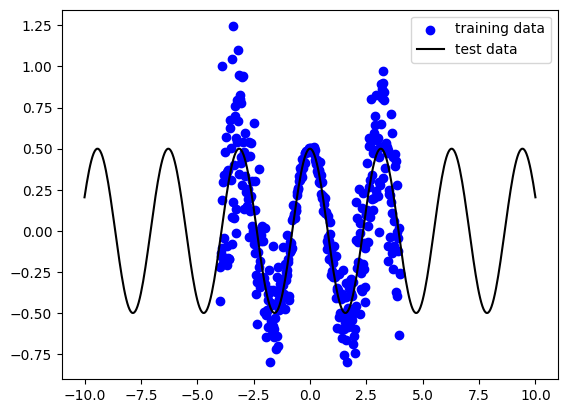

In [3]:
x1 = torch.rand(50, 1) * 0.3 - 1
x2 = torch.rand(100, 1) * 1 + 0.5
#x = torch.cat([x1, x2])
x = torch.linspace(-4, 4, 401).unsqueeze(-1)
cos_points = x.mul(2).cos().div(2)
y = cos_points + x/10 * torch.randn_like(x)

x_test = torch.linspace(-10, 10, 401).unsqueeze(-1)
y_test = x_test.mul(2).cos().div(2)

dataset = data.TensorDataset(x, y)
loader = data.DataLoader(dataset, batch_size=len(x))

plt.scatter(x.squeeze(), y, color="blue", label='training data')
plt.plot(x_test.squeeze(), y_test, color="black", label='test data')
plt.legend()

In [4]:
class DeepNormal(nn.Module):

    def __init__(self, n_inputs, n_hidden):
        super().__init__()

        # Shared parameters
        self.shared_layer = nn.Sequential(
            nn.Linear(n_inputs, n_hidden),
            nn.Tanh(),
            #nn.Dropout(),
        )
        
        # Mean parameters
        self.mean_layer = nn.Sequential(
            #nn.Linear(n_hidden, n_hidden),
            #nn.Tanh(),
            #nn.Dropout(),
            nn.Linear(n_hidden, 1),
        )
        
        # Standard deviation parameters
        self.std_layer = nn.Sequential(
            #nn.Linear(n_hidden, n_hidden),
            #nn.Tanh(),
            #nn.Dropout(),
            nn.Linear(n_hidden, 1),
            nn.Softplus(),  # enforces positivity
        )
             
    def forward(self, x):
        # Shared embedding
        shared = self.shared_layer(x)
        
        # Parametrization of the mean
        μ = self.mean_layer(shared)
        
        # Parametrization of the standard deviation
        σ = self.std_layer(shared)
        
        return torch.distributions.Normal(μ, σ)
    
def compute_loss(model, x, y):
    normal_dist = model(x)
    neg_log_likelihood = -normal_dist.log_prob(y)
    return torch.mean(neg_log_likelihood)

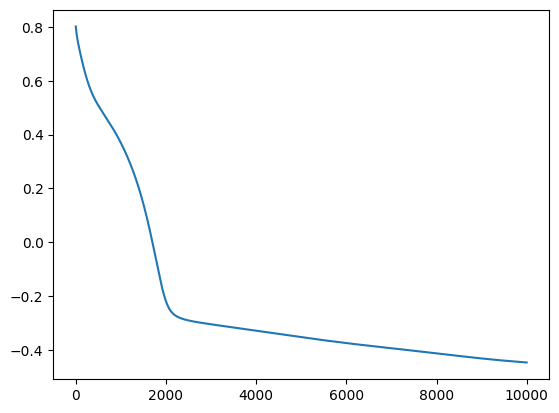

In [5]:
net = DeepNormal(n_inputs=1,n_hidden=50)
optim = torch.optim.Adam(net.parameters(), 1e-4)
n_epochs = 10000
losses = []
for e in range(n_epochs):
    optim.zero_grad()
    loss = compute_loss(net,x,y)
    loss.backward()
    optim.step()
    losses.append(loss.item())

plt.plot(range(len(losses)),losses)
plt.show()

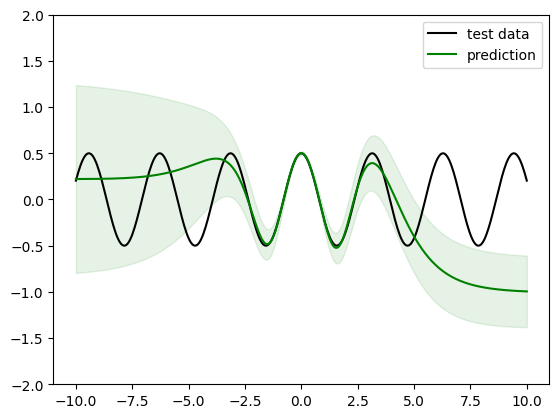

In [6]:
pred = net(x_test)
mu = pred.mean.detach()
error = (y_test.squeeze()-mu).pow(2)
std = pred.stddev.detach()

#plt.scatter(x.squeeze(), y, color="blue", label='training data')
plt.plot(x_test.squeeze(), y_test, color="black", label='test data')
plt.plot(x_test, mu.detach(), color="green", label='prediction')
plt.fill_between(x_test.squeeze(), (mu - std).squeeze(), (mu + std).squeeze(), alpha=0.1, color="green")
plt.ylim(-2, 2)
plt.legend()
plt.show()

# Laplace approximation